In [1]:
import pandas as pd
import numpy as np 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pickle  # Save and load model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msouh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
analyzer=SentimentIntensityAnalyzer()
vaderLex=analyzer.lexicon
print(vaderLex.get("love"))#Does not detect with CAPITAL letters

3.2


In [4]:
training_set=pd.read_csv("train.csv")

In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desc_id           1985 non-null   int64 
 1   source_name       1985 non-null   object
 2   review_text       1984 non-null   object
 3   is_accessibility  1985 non-null   object
 4   cleanText         1982 non-null   object
 5   Vader Sentiment   1985 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.2+ KB


### No nan Values

In [6]:
training_set.head()

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive
1,1,gp_AOqpTOGPKJI_1QuwFgSTcvd7BanaHdhJoLUXZDx8OVt...,I've used this on a different phone - but cur...,Accessibility Review,used different phone currently moto android re...,Positive
2,1,lg_AOqpTOE5_m1p9SEdAbCNs_Nh_qN7EHMLnyPnytEW9NX...,Fantastic program! Instant search results and...,Accessibility Review,fantastic program instant search results fast ...,Positive
3,1,lg_AOqpTOEyZAX-Z1qAqVvbqV8s6vJAttZvFBFixQTM_jW...,I'm using this on my mobile as well as on PC ...,Accessibility Review,using mobile well view offline dictionaries us...,Positive
4,1,gp_AOqpTOE6SfnT_RCAb9w8AbMpASAbJDvsJIHxp_xuhKg...,Text reflow doesn't work. I want my money back...,Accessibility Review,text reflow work want money back,Positive


In [7]:
training_set[training_set['Vader Sentiment']=="Neutral"].count()

desc_id             181
source_name         181
review_text         180
is_accessibility    181
cleanText           178
Vader Sentiment     181
dtype: int64

In [8]:
training_set = training_set.drop(index=training_set[training_set['Vader Sentiment'] == "Neutral"].index)#Dropping neutral sentiment


In [9]:
training_set[training_set['Vader Sentiment']=="Neutral"].count()

desc_id             0
source_name         0
review_text         0
is_accessibility    0
cleanText           0
Vader Sentiment     0
dtype: int64

In [10]:
training_set.head(1)

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment
0,1,gp_AOqpTOE-4PtpSwSKzv8CF6EtR6seFSLwg-QQPTpQKze...,Excellent app. Been using it for years on man...,Accessibility Review,excellent app using years many different phone...,Positive


In [11]:
def compute_score(text):
    scores = []
    if isinstance(text, str):  
        for word in text.split():  
            score = vaderLex.get(word, 0)
            scores.append(score)  
    return scores  

In [12]:
training_set['Numerical Features'] = training_set['cleanText'].apply(compute_score)#Applying the func for each row


In [13]:
training_set.tail(3)

,desc_id,source_name,review_text,is_accessibility,cleanText,Vader Sentiment,Numerical Features
1981,1,gp_AOqpTOGLFnORYm9M6DkAuG6-VJzlIUV0T4jPmGB7-gj...,it is realy nice - I loved it . it is top ca...,Accessibility Review,realy nice loved top candidate reader favorite...,Positive,"[0, 1.8, 2.9, 0.8, 0, 0, 2.0, 0, 0, 0, 0, 0, 0..."
1983,1,gp_AOqpTOGpOhiVI2WL_uwhHuu_ZhwYnTXwJLDPt-4-9_Z...,Slick layout and design and very functional b...,Accessibility Review,slick layout design functional sometimes throw...,Positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0..."
1984,1,gp_AOqpTOGpwNMVoUce48nQ7_cVsgQ7bnZ3LB0bjnJ3qmF...,I loved the app and all features including th...,Accessibility Review,loved app features including flexibility layou...,Positive,"[2.9, 0, 0, 0, 1.4, 0, 1.5, 0, 0, 0, 0, 0, 0, ..."


In [14]:
max_length = max(training_set['Numerical Features'].apply(len))


In [15]:
def pad_sequence(scores):
    return scores + [0] * (max_length - len(scores))

In [16]:
training_set['Conc_Features'] = training_set['Numerical Features'].apply(pad_sequence)

In [17]:
X = np.array(training_set['Conc_Features'].values.tolist())
y = (training_set["Vader Sentiment"]=="Positive").astype(int).values

In [18]:
def initialize_weights(n_features):  
    bias = 0
    weights = np.zeros(n_features)
    return weights, bias

def sigm_func(z):
    return 1 / (1 + np.exp(-z))

#Binary Cross Entropy with L2 regularization
def loss_func(y_true, y_pred, weights,lamb):
    m = len(y_true)
    loss = -(1/m) * np.sum(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))
    reg_term = (lamb / (2 * m)) * np.sum(weights**2)  # L2 Regularization
    return loss + reg_term


In [19]:
def gradient_descent(X, y, weights, bias, learning_rate, epochs,lamb):
    m = X.shape[0]  
    losses = []  
    accuracies = []
    velocity_w = np.zeros_like(weights)
    velocity_b = 0
    beta = 0.9      #Factor
    #Forward Pass
    for epoch in range(epochs):
        linear_model = np.dot(X, weights) + bias  # Linear combination
        y_pred = sigm_func(linear_model)  # Apply sigmoid 
        
        #Backward Pass
        dw = (1/m) * np.dot(X.T, (y_pred - y)) + (lamb/ m) * weights   # Gradient of weights with L2 Regu
        db = (1/m) * np.sum(y_pred - y)  # Gradient of bias

        velocity_w = beta * velocity_w + (1 - beta) * dw
        velocity_b = beta * velocity_b + (1 - beta) * db
        
        #Update the weights and bias
        weights -= learning_rate * velocity_w  
        bias -= learning_rate * velocity_b 

        if epoch % 20 == 0:
            loss = loss_func(y, y_pred,weights,lamb)
            losses.append(loss)

            y_pred_binary = (y_pred >= 0.5).astype(int)
            accuracy = accuracy_score(y, y_pred_binary)
            accuracies.append(accuracy)

            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


    return weights, bias, losses, accuracies

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=True)


In [21]:
#Using Standard Scaler for Features Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
learning_rate = 0.5
epochs = 320
lamb = 0.3
n_features = X_train.shape[1]

weights, bias = initialize_weights(n_features)
weights, bias, losses, accuracies = gradient_descent(X_train, y_train, weights, bias, learning_rate, epochs,lamb)

Epoch 0, Loss: 0.6931, Accuracy: 0.8787
Epoch 20, Loss: 0.2542, Accuracy: 0.9217
Epoch 40, Loss: 0.1680, Accuracy: 0.9480
Epoch 60, Loss: 0.1415, Accuracy: 0.9716
Epoch 80, Loss: 0.1277, Accuracy: 0.9751
Epoch 100, Loss: 0.1183, Accuracy: 0.9757
Epoch 120, Loss: 0.1113, Accuracy: 0.9771
Epoch 140, Loss: 0.1058, Accuracy: 0.9771
Epoch 160, Loss: 0.1013, Accuracy: 0.9806
Epoch 180, Loss: 0.0975, Accuracy: 0.9806
Epoch 200, Loss: 0.0943, Accuracy: 0.9827
Epoch 220, Loss: 0.0915, Accuracy: 0.9834
Epoch 240, Loss: 0.0890, Accuracy: 0.9848
Epoch 260, Loss: 0.0869, Accuracy: 0.9854
Epoch 280, Loss: 0.0850, Accuracy: 0.9875
Epoch 300, Loss: 0.0832, Accuracy: 0.9875


In [23]:
y_val_pred = sigm_func(np.dot(X_val, weights) + bias)  
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)  

final_accuracy = accuracy_score(y_val, y_val_pred_binary)
print(f"\nValidation Accuracy: {final_accuracy}")


Validation Accuracy: 0.961218836565097


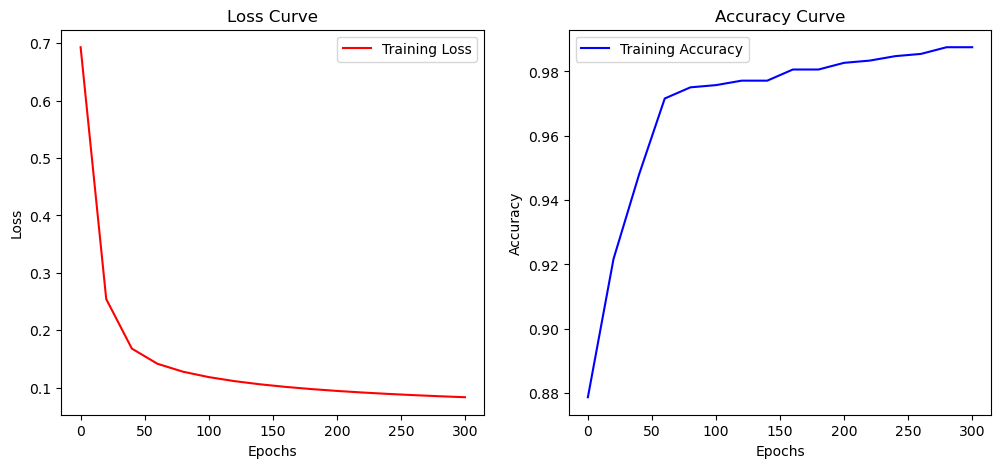

In [24]:
epochs_list = np.arange(0, epochs, 20)  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, losses, label="Training Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, accuracies, label="Training Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [25]:
model_data = {
    "weights": weights,
    "bias": bias
}

with open("model.pkl", "wb") as f:
    pickle.dump(model_data, f)
print("\nModel saved")


Model saved


In [26]:
test_set=pd.read_csv("test.csv")

In [27]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desc_id           594 non-null    int64 
 1   source_name       594 non-null    object
 2   review_text       594 non-null    object
 3   is_accessibility  594 non-null    object
 4   cleanText         594 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.3+ KB


In [28]:
test_set['Numerical Features'] = test_set['cleanText'].apply(compute_score)
test_set['Padded Features'] = test_set['Numerical Features'].apply(pad_sequence)


In [29]:
with open("model.pkl", "rb") as f:
    model_data = pickle.load(f)
weights, bias = model_data["weights"], model_data["bias"]


In [30]:
X_test = np.array(test_set['Padded Features'].tolist())
y_test_pred = sigm_func(np.dot(X_test, weights) + bias)  
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)  


In [31]:
test_set["id"] = range(len(test_set))

submission_df = pd.DataFrame({
    "id": test_set["id"],
    "Vader_Binary_Sentiment": y_test_pred_binary
})
submission_df.to_csv("submission.csv", index=False)
